In [1]:
# Import Library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
#Load Dataset
df = pd.read_csv("Rotten_Tomatoes_Clean.csv")

# Pilih kolom yang ingin ditampilkan
df_subset = df[["movie_title", "critics_consensus", "tomatometer_status"]]

# Reset index agar kolom nomor muncul
df_subset = df_subset.reset_index()
display(df_subset.head(6))
print("Jumlah Baris awal : ", len(df_subset))
# Gunakan kolom review sebagai input dan status sebagai label
df = df[['critics_consensus', 'tomatometer_status']].dropna()

total_data = len(df)
print("Total data setelah seleksi:", total_data)

# Hitung jumlah data untuk setiap status (fresh vs rotten)
status_counts = df['tomatometer_status'].value_counts()
print("\nJumlah data per kategori:")
print(status_counts)

# Jika ingin dalam persentase
status_percentage = df['tomatometer_status'].value_counts(normalize=True) * 100
print("\nPersentase tiap kategori:")
print(status_percentage.round(2))


# Pembersihan Teks
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z']", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df['clean_review'] = df['critics_consensus'].apply(clean_text)


,index,movie_title,critics_consensus,tomatometer_status
0,0,Percy Jackson & the Olympians: The Lightning T...,Though it may seem like just another Harry Pot...,Rotten
1,1,Please Give,Nicole Holofcener's newest might seem slight i...,Fresh
2,2,10,NaN,Fresh
3,3,12 Angry Men (Twelve Angry Men),Sidney Lumet's feature debut is a superbly wri...,Fresh
4,4,"20,000 Leagues Under The Sea","One of Disney's finest live-action adventures,...",Fresh
5,5,"10,000 B.C.",With attention strictly paid to style instead ...,Rotten


Jumlah Baris awal :  16638
Total data setelah seleksi: 8309

Jumlah data per kategori:
Fresh     4917
Rotten    3392
Name: tomatometer_status, dtype: int64

Persentase tiap kategori:
Fresh     59.18
Rotten    40.82
Name: tomatometer_status, dtype: float64


In [ ]:
# Label encoding
df['label'] = df['tomatometer_status'].apply(lambda x: 1 if x == 'Fresh' else 0)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(
    #df['critics_consensus'], df['label'], test_size=0.2, random_state=42)

# Tahap 1: pisahkan test 10% dulu
# Tahap 1: pisahkan 10% untuk test
X_temp, X_test, y_temp, y_test = train_test_split(
    df['clean_review'], df['label'],
    test_size=0.1,
    random_state=42,
    stratify=df['label']
)

# Tahap 2: dari sisa (90%), ambil 10% untuk validasi → berarti 10% dari total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1111,  # 0.1111 * 0.9 ≈ 0.1 total dataset
    random_state=42,
    stratify=y_temp
)

print(f"Total data: {len(df)}")
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Total data: 8309
Train: 6647 | Val: 831 | Test: 831


In [ ]:
#Tokenisasi dan Padding

vocab_size = 10000
maxlen = 150
import pickle

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
# ✅ Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved → tokenizer.pkl")

def pad_text(data):
    seq = tokenizer.texts_to_sequences(data)
    pad = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
    return pad

X_train_pad = pad_text(X_train)
X_val_pad = pad_text(X_val)
X_test_pad = pad_text(X_test)

#X_train_seq = tokenizer.texts_to_sequences(X_train)
#X_test_seq = tokenizer.texts_to_sequences(X_test)

#X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
#X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')


✅ Tokenizer saved → tokenizer.pkl


In [ ]:
# Load GloVe vectors
import numpy as np
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:
# Bangun Model Bidirectional BiLSTM dengan GloVe
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.4)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [ ]:
#Kompilasi Model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=64,
    validation_split=0.1,  # 10% dari training untuk validasi
    callbacks=[es],
    verbose=1
)
# ✅ Save model
model.save("sentiment_lstm_glove.h5")
print("✅ Model saved → sentiment_lstm_glove.h5")

Epoch 1/4
94/94 [==============================] - 45s 437ms/step - loss: 0.6386 - accuracy: 0.6147 - val_loss: 0.5271 - val_accuracy: 0.7910
Epoch 2/4
94/94 [==============================] - 40s 421ms/step - loss: 0.4507 - accuracy: 0.8001 - val_loss: 0.3582 - val_accuracy: 0.8556
Epoch 3/4
94/94 [==============================] - 41s 435ms/step - loss: 0.3421 - accuracy: 0.8537 - val_loss: 0.3312 - val_accuracy: 0.8737
Epoch 4/4
94/94 [==============================] - 41s 441ms/step - loss: 0.2845 - accuracy: 0.8821 - val_loss: 0.3057 - val_accuracy: 0.8707
✅ Model saved → sentiment_lstm_glove.h5


In [ ]:
#Evaluasi Model
loss, acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"\n🎯 Akurasi data uji: {acc*100:.2f}%")
# Prediksi
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")



🎯 Akurasi data uji: 87.85%
26/26 [==============================] - 1s 20ms/step


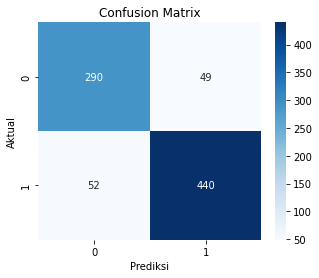


📋 Classification Report:
              precision    recall  f1-score   support

  Rotten (0)       0.85      0.86      0.85       339
   Fresh (1)       0.90      0.89      0.90       492

    accuracy                           0.88       831
   macro avg       0.87      0.87      0.87       831
weighted avg       0.88      0.88      0.88       831



In [ ]:
# Confusion Matrix dan Classification Report
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Rotten (0)', 'Fresh (1)']))



In [ ]:
# Uji Prediksi
sample_texts = [
    "This movie was absolutely fantastic, a masterpiece!",
    "I really hated this movie, it was so boring and slow.",
    "The film was okay, not great but not terrible either."
]

sample_seq = tokenizer.texts_to_sequences([clean_text(t) for t in sample_texts])
sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')
preds = model.predict(sample_pad)

for t, p in zip(sample_texts, preds):
    print(f"{t} --> {'Fresh 🍅' if p >= 0.5 else 'Rotten 💀'} ({p[0]:.2f})")


1/1 [==============================] - 0s 23ms/step
This movie was absolutely fantastic, a masterpiece! --> Fresh 🍅 (0.59)
I really hated this movie, it was so boring and slow. --> Rotten 💀 (0.07)
The film was okay, not great but not terrible either. --> Rotten 💀 (0.06)


In [ ]:
import matplotlib.pyplot as plt

# --- Plot Accuracy ---
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

<Figure size 720x360 with 0 Axes>

Accuracy: 0.8784596871239471
Error rate: 0.12154031287605294


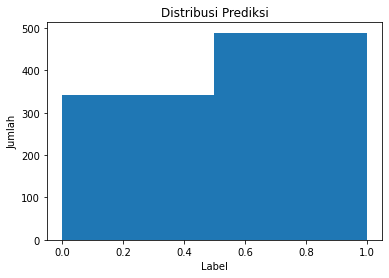

1/1 [==============================] - 0s 34ms/step


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
error_rate = 1 - acc

print("Accuracy:", acc)
print("Error rate:", error_rate)

plt.figure(figsize=(6,4))
plt.hist(y_pred, bins=len(np.unique(y_pred)))
plt.title("Distribusi Prediksi")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()



In [ ]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 150

# ====== FUNCTION PREDICTION ======
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

    score = float(model.predict(padded)[0][0])   # sigmoid → prob positif
    label = "Positive" if score >= 0.5 else "Negative"

    return label, score


# ====== GRADIO APP ======
def gradio_predict(text):
    label, score = predict_sentiment(text)

    positive_prob = score
    negative_prob = 1 - score

    # --- Membuat grafik bar ---
    fig, ax = plt.subplots(figsize=(4, 3))
    sentiments = ["Positive", "Negative"]
    probabilities = [positive_prob, negative_prob]
    colors = ["green", "red"]

    ax.bar(sentiments, probabilities, color=colors)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title("Sentiment Probability Distribution")

    # Tampilkan nilai di atas batang
    for i, v in enumerate(probabilities):
        ax.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', fontweight='bold')

    result = {
        "Predicted Sentiment": label,
        "Confidence": f"{max(score, 1-score)*100:.2f}%",
        "Positive Probability": f"{positive_prob*100:.2f}%",
        "Negative Probability": f"{negative_prob*100:.2f}%"
    }

    return result, fig


with gr.Blocks() as demo:
    gr.Markdown("## 🎬 Prediksi Sentimen Rotten Tomatoes (dengan Grafik)")

    inp = gr.Textbox(label="Masukkan review film", lines=4, placeholder="Tulis ulasan film di sini...")

    with gr.Row():
        out_json = gr.JSON(label="Hasil Prediksi")
        out_plot = gr.Plot(label="Distribusi Probabilitas Sentimen", format="png")

    btn = gr.Button("🔍 Analisis Sentimen")

    btn.click(fn=gradio_predict, inputs=inp, outputs=[out_json, out_plot])

demo.launch()


Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


1/1 [==============================] - 0s 42ms/step
